In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from time import time
from keras.layers import Dense, Input,Conv1D, MaxPooling1D, Flatten, Embedding, Reshape, UpSampling1D
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import TensorBoard
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
import pickle

from scipy import special

Using TensorFlow backend.


In [2]:
P = np.array([
    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
    [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
    [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
    [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0],
    [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
    [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1],
], dtype='int')

In [3]:
def custom_activation(x):
    return 1 / (1 + keras.backend.exp(-x))

In [4]:
def syndrome_decoding(codes):
    with open('syndrome.pickle', 'rb') as syn:
        syndrome = pickle.load(syn)
        
    H = np.concatenate((np.eye(11, dtype="int"), P.T), axis=1)
    fix_code = []
    for code in codes:
        code_syndrome = tuple(np.dot(code, H.T) % 2)
        error_code = syndrome[code_syndrome]
        fix_code.append((code + error_code) % 2)
    return np.array(fix_code)

In [5]:
def awgn(x_input, Es_No):
    sig_power = 1
    
    noise_power = np.sqrt(sig_power / (2 * Es_No))
    
    noise = noise_power * np.random.normal(size = x_input.shape)
    
    return x_input + noise

In [6]:
def mld_func(x_noisy):
    codeword = np.loadtxt('input.txt')

    for i in range(x_noisy.shape[0]):
        check = np.dot(x_noisy[i, :], codeword.T)
        max_check = np.max(check)
        index = np.where(check == max_check)[0][0]
        if i == 0:
            mld_code = codeword[index, :]
        else :
            mld_code = np.vstack((mld_code, codeword[index, :]))
 
    return np.where(mld_code < 0, 1, 0)

In [7]:
syn_BER = np.zeros(11)
golay_BER = np.zeros(11)
mld_BER = np.zeros(11)
mld_ae_BER = np.zeros(11)

In [8]:
# model = load_model('model_relu_softstep_0.4.h5', custom_objects={'custom_activation':custom_activation})

In [9]:
model = load_model('model_cus_relu.h5')

In [10]:
file_buffer = 'result/syn_ae_result_3.txt'
syn_ae_f = open(file_buffer, 'w')

file_buffer = 'result/MLD_result_3.txt'
mld_f = open(file_buffer, 'w')

file_buffer = 'result/MLD_ae_result_3.txt'
mld_ae_f = open(file_buffer, 'w')

file_buffer = 'result/golay_result_3.txt'
golay_f = open(file_buffer, 'w')

for i in range(0, 11):
    total_syn_BER = 0
    total_mld_BER = 0
    total_mld_ae_BER = 0
    total_golay_BER = 0

    print(i,'Eb/No start')
    
    for j in range(10**2):
        Eb_No = 10**(i/10)
        Es_No = Eb_No * (12/23)
    
        m = np.random.randint(2, size=(10, 12))
        G= np.concatenate((P, np.eye(12, dtype="int")), axis=1)
        x_test = np.dot(m, G) % 2
        x_test = np.where(x_test > 0, -1, 1)
    
        x_test_noisy = awgn(x_test, Es_No)
    
#         x_input = (x_test_noisy + 1) / 2
        x_input = x_test_noisy
        x_demod = x_test_noisy
    
        x_demod = np.where(x_demod < 0, 1, 0)   
    
        #auto encoding start
        decoded_codes = model.predict(x_input, verbose=0)
    
        decoded_codes = np.reshape(decoded_codes, (x_input.shape[0], 23))

        #mld
        mld_code = mld_func(x_test_noisy)
        mld_ae_code = mld_func(decoded_codes)
                   
        #syndrome start
        decoded_codes = np.where(decoded_codes < 0, 1, 0)   

        fix_code = syndrome_decoding(decoded_codes)
        golay_code = syndrome_decoding(x_demod)

        syn_count = ((m + fix_code[:,11:])%2).sum()
        mld_count = ((m + mld_code[:,11:])%2).sum()
        mld_ae_count = ((m + mld_ae_code[:,11:])%2).sum()
        golay_count = ((m + golay_code[:,11:])%2).sum()

        total_syn_BER += syn_count / (m.shape[0] * m.shape[1])
        total_mld_BER += mld_count / (m.shape[0] * m.shape[1])
        total_mld_ae_BER += mld_ae_count / (m.shape[0] * m.shape[1])
        total_golay_BER += golay_count / (m.shape[0] * m.shape[1])
    
    syn_BER[i] = total_syn_BER/(10**2)
    mld_BER[i] = total_mld_BER/(10**2)
    mld_ae_BER[i] = total_mld_ae_BER/(10**2)
    golay_BER[i] = total_golay_BER/(10**2)
    
    write_buffer = 'Eb_No, %f, ' %(i)
    syn_ae_f.write(write_buffer)
    mld_f.write(write_buffer)
    mld_ae_f.write(write_buffer)
    golay_f.write(write_buffer)
    
    write_buffer = 'BER, %.10f\n' % (syn_BER[i])
    syn_ae_f.write(write_buffer)
    write_buffer = 'BER, %.10f\n' % (mld_BER[i])
    mld_f.write(write_buffer)
    write_buffer = 'BER, %.10f\n' % (mld_ae_BER[i])
    mld_ae_f.write(write_buffer)
    write_buffer = 'BER, %.10f\n' % (golay_BER[i])
    golay_f.write(write_buffer)
    
    print(i,'Eb/No end')
syn_ae_f.close()
mld_f.close()
mld_ae_f.close()
golay_f.close()

0 Eb/No start
0 Eb/No end
1 Eb/No start
1 Eb/No end
2 Eb/No start
2 Eb/No end
3 Eb/No start
3 Eb/No end
4 Eb/No start
4 Eb/No end
5 Eb/No start
5 Eb/No end
6 Eb/No start
6 Eb/No end
7 Eb/No start
7 Eb/No end
8 Eb/No start
8 Eb/No end
9 Eb/No start
9 Eb/No end
10 Eb/No start
10 Eb/No end


In [11]:
bpsk_BER = np.zeros(11)
for i in range(0,11):
    bpsk_BER[i] = 0.5 * special.erfc((np.sqrt(10**(i/10))))

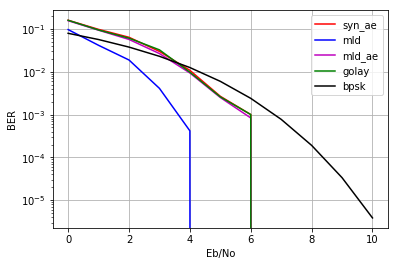

In [12]:
x = np.array(range(0, 11))

plt.semilogy(x,syn_BER, label='syn_ae', color='r')
plt.semilogy(x,mld_BER, label='mld', color='b')
plt.semilogy(x,mld_ae_BER, label='mld_ae', color='m')
plt.semilogy(x,golay_BER, label='golay', color='g')
plt.semilogy(x,bpsk_BER, label='bpsk', color='k')
# plt.semilogy(x,bpsk_BER, label='bpsk', color='k')


plt.xlabel('Eb/No')
plt.ylabel('BER')

plt.legend()
plt.grid(True)
plt.show()